# F21DL: Clustering

## Motivation

Growing up, I have always been fascinated with Japanese language and culture. After I was told my wine dataset from Stage 1 would be too easy for subsequent parts, I searched for japanese character datasets and found the Kuzushiji-MNIST dataset. It has 3 datasets, and I chose to work with the one with 49 classes that represent the old Hiragana characters. I skipped the 10 class one because that might be too simple, and skipped the kanji one because I have a preference for hiragana having learned it myself in past.

### Preparation

In [1]:
import os
import sys
import sklearn
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [3]:
# Training data
with np.load("./kmnist/k49-train-imgs.npz") as xTrain:
    xTrain = xTrain['arr_0']

# Training labels
with np.load("./kmnist/k49-train-labels.npz") as yTrain:
    yTrain = yTrain["arr_0"]

# Testing data 
with np.load("./kmnist/k49-test-imgs.npz") as xTest:
    xTest = xTest["arr_0"]

#Testing labels
with np.load("./kmnist/k49-test-labels.npz") as yTest:
    yTest = yTest["arr_0"]

### Exploration

In [4]:
# Credit: HÙNG NGỌC PHÁT, https://www.kaggle.com/hiraki01/hiraganamnist
def showRandom100Examples(X, y, imgdim=28):
    # Generate 100 random indices
    random_idx = np.random.randint(0, X.shape[0], 100)
    random_set = X[random_idx]
    random_set = random_set.reshape(10, 10, imgdim, imgdim)
    # Create 10x10 grid
    fig, ax = plt.subplots(10, 10, figsize=(10, 10))
    for i in range(random_set.shape[0]):
        for j in range(random_set.shape[1]):
            example = random_set[i, j]
            ax[i, j].imshow(example)
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
    plt.show()

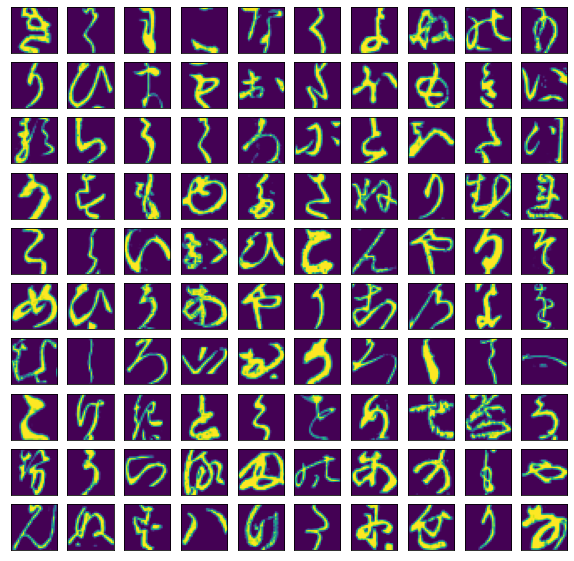

In [5]:
# View 100 random images from dataset
showRandom100Examples(xTrain, 0)

In [6]:
xTrain.shape

(232365, 28, 28)

In [7]:
yTrain.shape

(232365,)

In [8]:
unique_classes = np.unique(yTrain) 
num_class = len(unique_classes)
print(f"Classes: {num_class}")
print(unique_classes)

Classes: 49
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48]


In [9]:
frequency = np.asarray(np.unique(yTrain, True)).T
print(frequency)

[[  0  28]
 [  1  33]
 [  2  30]
 [  3  51]
 [  4   5]
 [  5  69]
 [  6  32]
 [  7   4]
 [  8  34]
 [  9 131]
 [ 10  25]
 [ 11 142]
 [ 12  22]
 [ 13  24]
 [ 14  56]
 [ 15  16]
 [ 16  83]
 [ 17 120]
 [ 18  35]
 [ 19   1]
 [ 20   2]
 [ 21  36]
 [ 22  96]
 [ 23 169]
 [ 24   8]
 [ 25  13]
 [ 26  42]
 [ 27  17]
 [ 28  41]
 [ 29 190]
 [ 30   0]
 [ 31  61]
 [ 32 258]
 [ 33 119]
 [ 34  46]
 [ 35   6]
 [ 36  87]
 [ 37  26]
 [ 38  63]
 [ 39  40]
 [ 40  27]
 [ 41  38]
 [ 42  74]
 [ 43   9]
 [ 44  70]
 [ 45 130]
 [ 46  12]
 [ 47  18]
 [ 48 106]]


In [10]:
np.unique(xTrain)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

### Observations
1. There are 232365 images/instances in the training data.
2. Each image is represented by a 28 * 28 matrix.
3. The above matrix contains greyscale value ranging from 0 to 255.
4. There are a total of 49 classes/characters in this dataset.
5. **Data is imbalanced.**
    1. The character む, represented by index 32 or code U+3080, has a much higher share with 258 observations.
    2. Index such as 19 and 20 have only 1 and 2 observations respectively.
    3. Index 30 has zero observations.

In [11]:
# Flatten the 28*28 matrix so that each image is represented in one row.
xTrain = xTrain.reshape(-1, 28*28)

In [12]:
xTrain.shape

(232365, 784)

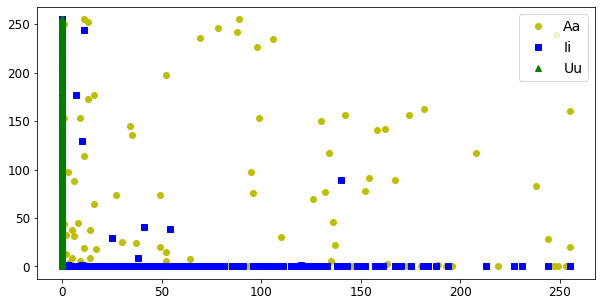

In [13]:
plt.figure(figsize=(10, 5))
plt.plot(xTrain[yTrain==0, 1], xTrain[yTrain==0, 10], "yo", label="Aa")
plt.plot(xTrain[yTrain==1, 1], xTrain[yTrain==1, 10], "bs", label="Ii")
plt.plot(xTrain[yTrain==2, 1], xTrain[yTrain==2, 10], "g^", label="Uu")
plt.legend(fontsize=14, loc='upper right')
plt.show()

# This plot looks weird because the x and y axes are just
# the 2nd and 11th pixel values. Was not sure how else to display it.

**Note:** I am not addressing the data imbalance right now as I do not have time. Might do it at the end as use it for comparison.

## K-Means

In [14]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from kneed import KneeLocator

In [15]:
# Standardizing data
scaler = StandardScaler()
xtrain = scaler.fit_transform(xTrain)

In [16]:
kmeans = KMeans(n_clusters=15, random_state=42, init="k-means++")
y_pred = kmeans.fit_predict(xTrain)

In [17]:
y_pred

array([ 0, 11, 13, ...,  5,  0,  4], dtype=int32)

In [18]:
y_pred is kmeans.labels_

True

In [19]:
kmeans.cluster_centers_

array([[ 0.03986424,  0.05562586,  0.15882421, ...,  0.78664289,
         0.28129314,  0.07466636],
       [ 0.73581729,  1.73237684,  3.13264036, ...,  6.04194422,
         2.78830247,  0.72425152],
       [ 0.61396588,  1.66865672,  3.64168443, ..., 20.4696162 ,
         8.76066098,  2.20159915],
       ...,
       [ 1.46437905,  3.69696625,  6.1506647 , ...,  6.98420634,
         4.31666856,  1.50721509],
       [ 0.07069782,  0.32378989,  0.81096351, ...,  1.39754161,
         0.62551535,  0.14590014],
       [ 0.43065342,  1.14682325,  2.64546823, ...,  7.49641674,
         4.32177055,  1.43167721]])

In [20]:
len(kmeans.cluster_centers_)

15

In [21]:
kmeans.n_iter_

117

In [22]:
# Flatten test data
xTest = xTest.reshape(-1, 28*28)

# Standardizing data
scaler = StandardScaler()
scaler.fit(xTest)
xTest = scaler.fit_transform(xTest)

In [23]:
kmeans.predict(xTest)

array([10, 10, 10, ..., 10, 10, 10], dtype=int32)

### Choosing Number of Clusters: Elbow Method

In [ ]:
kmeans_kwargs = {
    "init": "k-means++",
    "max_iter": 10,
    "random_state": 42
}

sse = []
for k in range(1,15):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(xTest)
    sse.append(kmeans.inertia_)

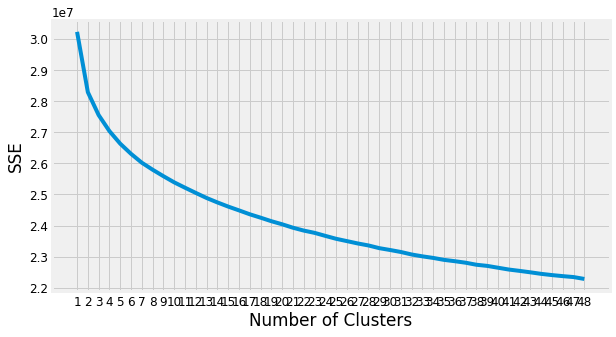

In [25]:
plt.figure(figsize=(10,5))
plt.style.use("fivethirtyeight")
plt.plot(range(1,49), sse)
plt.xticks(range(1,49))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [26]:
kl = KneeLocator(range(1,49), sse, curve="convex", direction="decreasing")
kl.elbow

11

### Observation
1. 11 clusters seem to be the elbow point.

## Dimension Reductionality: Isomap

In [27]:
import plotly.express as px 
from sklearn.manifold import Isomap

In [28]:
# iso = Isomap(n_components=3)
# xIsomap = iso.fit_transform(xtrain)

In [29]:
# print(f"Shape of X before: {xtrain.shape}")
# print(f"Shape of X before: {xIsomap.map}")

In [30]:
# # Create a 3D scatter plot
# fig = px.scatter_3d(None, 
#                     x=xIsomap[:,0], y=xIsomap[:,1], z=xIsomap[:,2],
#                     color=y.astype(str),
#                     height=900, width=900
#                    )

# # Update chart looks
# fig.update_layout(#title_text="Scatter 3D Plot",
#                   showlegend=True,
#                   legend=dict(orientation="h", yanchor="top", y=0, xanchor="center", x=0.5),
#                   scene_camera=dict(up=dict(x=0, y=0, z=1), 
#                                         center=dict(x=0, y=0, z=-0.2),
#                                         eye=dict(x=-1.5, y=1.5, z=0.5)),
#                                         margin=dict(l=0, r=0, b=0, t=0),
#                   scene = dict(xaxis=dict(backgroundcolor='white',
#                                           color='black',
#                                           gridcolor='#f0f0f0',
#                                           title_font=dict(size=10),
#                                           tickfont=dict(size=10),
#                                          ),
#                                yaxis=dict(backgroundcolor='white',
#                                           color='black',
#                                           gridcolor='#f0f0f0',
#                                           title_font=dict(size=10),
#                                           tickfont=dict(size=10),
#                                           ),
#                                zaxis=dict(backgroundcolor='lightgrey',
#                                           color='black', 
#                                           gridcolor='#f0f0f0',
#                                           title_font=dict(size=10),
#                                           tickfont=dict(size=10),
#                                          )))

# # Update marker size
# fig.update_traces(marker=dict(size=2))

# fig.show()

<div class="alert alert-block alert-danger">
    <b> Problem: </b> Tried transforming data for Isomap in the above cells but the execution never stops. Kept it running for few hours and still nothing. Have not been able to debug it so no data or plots for the map </b>
    </div>

## Dimension Reductionality: PCA

In [33]:
from sklearn.decomposition import PCA

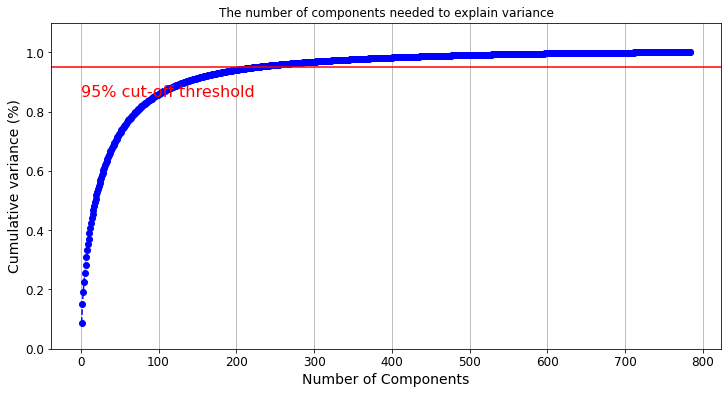

In [22]:
pca = PCA().fit(xTrain)
plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(1, 785, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

### Observation 
1. If we wanted to reduce the dimensions while still being able to explain 95% of the variance in our data, we could do so by reducing dimensions from 784 to roughly 200.
2. Eye-balling the above figure, roughly 70% of the variance can be explained if we reduced our dimensions to 50. 
3. Either way, still way too many dimensions to graph properly.

In [34]:
#Create a PCA model with two principal components
pca = PCA(200)
#Get the components from transforming the original data.
xPCA = pca.fit_transform(xTrain)

## Decision Boundaries

In [24]:

def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=35, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=2, linewidths=12,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

In [29]:
# plt.figure(figsize=(8, 4))
# plot_decision_boundaries(kmeans, xTrain)
# plt.show()

<div class="alert alert-block alert-danger">
    <b> Problem: </b> Could not get the graph to work, kept raising Value error.</b>
    </div>

## Different Algorithm: EM

In [31]:
from sklearn.mixture import GaussianMixture

In [ ]:
gm = GaussianMixture(n_components=200, n_init=10, random_state=42)
gm.fit(xTrain)

In [ ]:
gm.weights_

In [ ]:
gm.means_

In [ ]:
gm.covariances_

In [ ]:
gm.converged_

In [ ]:
gm.n_iter_

In [ ]:
gm.predict(xTest)

In [ ]:
gm.predict_proba(xTest)

<div class="alert alert-block alert-danger">
    <b> Problem: </b> This algorithm is stuck on loading as well. Cant run, cant compare.</b>
    </div>

### Bibliography

1. Arvai, K. (2021). K-Means Clustering in Python: A Practical Guide – Real Python. Retrieved 4 November 2021, from https://realpython.com/k-means-clustering-python/

1. Natakarnkitkul, S. (2021). Dimension Reduction Tutorial on Kuzushiji MNIST. Retrieved 3 November 2021, from https://medium.com/@net_satsawat/dimension-reduction-tutorial-on-kuzushiji-mnist-93419101474e

1. PHÁT, H. (2021). HiraganaMNIST. Retrieved 3 November 2021, from https://www.kaggle.com/hiraki01/hiraganamnist